In [1]:
import importlib.util
import subprocess

# Lista de paquetes que queremos instalar si no están presentes
packages = [
    "numpy",
    "pandas",
    "skforecast"
]

# Función para verificar e instalar paquetes
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Instalando {package}...")
        subprocess.check_call(["pip", "install", package])
    else:
        print(f"{package} ya está instalado.")

# Iterar sobre la lista de paquetes
for package in packages:
    install_if_missing(package)

numpy ya está instalado.
pandas ya está instalado.
Instalando skforecast...


In [2]:
# Importamos las librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Importamos librerías para visualización
from seaborn import heatmap
from matplotlib import pyplot as plt

# Análisis y estadísticas
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox

# Machine Learning y preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Forecasting con Skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster

# SHAP para interpretabilidad de modelos
import shap
import joblib

In [25]:
df=pd.read_excel('/content/monthly_data_per_unit.xlsx',index_col=0)
df.index = pd.to_datetime(df.index).to_period('M')
df.head(),df.index

(         Net_Summer_Capacity_MW  Net_Generation_MWh  \
 Date                                                  
 1994-12                0.909615          555.018349   
 1995-01                0.909615          581.119266   
 1995-02                0.909615          475.761468   
 1995-03                0.909615          475.963303   
 1995-04                0.909615          452.486239   
 
          Share_of_Electricity_Percent  Capacity_Factor_Percent  
 Date                                                            
 1994-12                      0.205505                 0.752294  
 1995-01                      0.207339                 0.788073  
 1995-02                      0.188991                 0.713761  
 1995-03                      0.182569                 0.644954  
 1995-04                      0.185321                 0.634862  ,
 PeriodIndex(['1994-12', '1995-01', '1995-02', '1995-03', '1995-04', '1995-05',
              '1995-06', '1995-07', '1995-08', '1995-09',
     

In [3]:
def escalar_xy(data, variables_exogoenas):
    """
    Escala la(s) variable(s) exogenas y extrae la variable dependiente del conjunto de datos proporcionado.

    Parámetros:
    - data (pd.DataFrame): DataFrame con los datos originales, debe contener las columnas necesarias.
    - variables (list): Lista de nombres de las variables exógenas a escalar.

    Retorna:
    - X_escalado (pd.DataFrame): DataFrame con las variables exógenas escaladas.
    - Y_data (pd.Series): Serie con la variable dependiente "Net_Generation_MWh".
    - scalers (dict): Diccionario con los `StandardScaler()` usados para cada variable.
    """
    scalers = {}  # Diccionario para almacenar los scalers

    # Extraer y escalar cada variable exógena individualmente
    X_escalado = pd.DataFrame(index=data.index)

    for col in variables_exogoenas:
        scaler = StandardScaler()
        X_escalado[col] = scaler.fit_transform(data[[col]])  # Escalar la columna
        scalers[col] = scaler  # Guardar el scaler usado


    # Seleccionar la variable dependiente
    Y_data = data["Net_Generation_MWh"]

    return X_escalado, Y_data, scalers

In [17]:
import pickle
#Cargar X e Y
X_escalado = pd.read_excel("/content/X_escalado.xlsx")
X_escalado.set_index(X_escalado['Date'], inplace=True)
X_escalado.drop('Date', axis=1, inplace=True)
Y_escalado = pd.read_excel("/content/Y_escalado.xlsx")
Y_escalado.set_index(Y_escalado['Date'], inplace=True)
Y_escalado.drop('Date', axis=1, inplace=True)

# Cargar scalers
scalers = joblib.load("/content/scalers.pkl")

# Cargar modelos SARIMAX con joblib
SARIMAX_Net_Summer_Capacity_MW = joblib.load("/content/SARIMAX_Net_Summer_Capacity_MW.joblib")
SARIMAX_Capacity_Factor_Percent = joblib.load("/content/SARIMAX_Capacity_Factor_Percent.joblib")

# Cargar modelo Ridge con Skforecast
#modelo_ridge_NetGeneration = load_forecaster("/content/modelo_ridge_NetGeneration.joblib")


modelo_ridge_NetGeneration = joblib.load("/content/modelo_ridge_NetGeneration.pkl")

================ 
ForecasterDirect 
================ 
Regressor: Ridge 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] 
Window features: None 
Window size: 34 
Maximum steps to predict: 180 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1994-12-01 00:00:00'), Timestamp('2024-11-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-03-18 09:47:11 
Last fit date: 2025-03-18 09:47:12 
Skforecast version: 0.15.0 
Python version: 3.11.11 
Forecaster id: None

In [13]:
# Preguntar al usuario si quiere predecir con SARIMAX
usar_sarimax = input("¿Quieres predecir variables exógenas con SARIMAX? (Yes/No): ").strip().lower()

if usar_sarimax in ["y", "yes", "sí", "si"]:
    # Pedir al usuario cuántos años quiere predecir
    años = int(input("¿Cuántos años quieres predecir?  : ").strip())

    # Convertir años a pasos (steps) de predicción
    steps = años * 12  # 12 meses por año

    # Realizar predicciones con los modelos SARIMAX
    pred_sarimax_Net_Summer = SARIMAX_Net_Summer_Capacity_MW.predict(steps=steps)[:steps]  # Forzar solo 'steps' meses
    pred_sarimax_Capacity = SARIMAX_Capacity_Factor_Percent.predict(steps=steps)[:steps]  # Forzar solo 'steps' meses

    # Generar fechas futuras basadas en la cantidad exacta de pasos
    future_dates = pd.date_range(start=Y_escalado.index[-1] + pd.DateOffset(months=1),
                                 periods=steps, freq="MS")

    # Asignar manualmente el índice de fechas futuras
    pred_sarimax_Net_Summer.index = future_dates
    pred_sarimax_Capacity.index = future_dates
    #pred_sarimax_Net_Summer = pd.DataFrame(pred_sarimax_Net_Summer, columns=["Predicción Net Summer Capacity MW"])
    #pred_sarimax_Capacity = pd.DataFrame(pred_sarimax_Capacity, columns=["Predicción Capacity Factor Percent"])

    # Inversa la transformación
    # Inversa de la transformación, asegurando que el array sea 2D
    Net_summer_capacity_predict = scalers['Net_Summer_Capacity_MW'].inverse_transform(pred_sarimax_Net_Summer.values.reshape(-1, 1))
    Capacity_factor_predict = scalers['Capacity_Factor_Percent'].inverse_transform(pred_sarimax_Capacity.values.reshape(-1, 1))


    # Mostrar resultados
    print("\n Predicciones SARIMAX para Net Summer Capacity MW:")
    print(Net_summer_capacity_predict)

    print("\n Predicciones SARIMAX para Capacity Factor Percent:")
    print(Capacity_factor_predict)

else:
    print("\n❌ No se realizó predicción con SARIMAX.")



¿Quieres predecir variables exógenas con SARIMAX? (Yes/No): y
¿Cuántos años quieres predecir?  : 10

 Predicciones SARIMAX para Net Summer Capacity MW:
[[0.97586899]
 [0.91649056]
 [0.90454959]
 [0.91091611]
 [0.90898324]
 [0.90981702]
 [0.90953041]
 [0.90964428]
 [0.91237202]
 [0.91339476]
 [0.91287117]
 [0.91303385]
 [0.87152417]
 [0.90366358]
 [0.91788302]
 [0.91602681]
 [0.91834063]
 [0.91703008]
 [0.9175625 ]
 [0.92043702]
 [0.91783816]
 [0.91705877]
 [0.91709906]
 [0.9176363 ]
 [0.9145953 ]
 [0.92460941]
 [0.92853452]
 [0.92598727]
 [0.9249199 ]
 [0.92500535]
 [0.92469531]
 [0.92508857]
 [0.924726  ]
 [0.9301396 ]
 [0.9310949 ]
 [0.93130933]
 [0.9378983 ]
 [0.93364062]
 [0.94677816]
 [0.94973206]
 [0.94833881]
 [0.94976726]
 [0.94924954]
 [0.94990103]
 [0.94037092]
 [0.93601591]
 [0.93488443]
 [0.93414841]
 [0.93787326]
 [0.94108742]
 [0.93897106]
 [0.93891193]
 [0.93760896]
 [0.93795135]
 [0.93752293]
 [0.93367488]
 [0.93917545]
 [0.93778791]
 [0.93753067]
 [0.93761649]
 [0.9401

Date
1994-12    555.018349
1995-01    581.119266
1995-02    475.761468
1995-03    475.963303
1995-04    452.486239
              ...    
2024-07    743.457447
2024-08    742.127660
2024-09    666.595745
2024-10    621.670213
2024-11    658.553191
Freq: M, Name: Net_Generation_MWh, Length: 360, dtype: float64 PeriodIndex(['1994-12', '1995-01', '1995-02', '1995-03', '1995-04', '1995-05',
             '1995-06', '1995-07', '1995-08', '1995-09',
             ...
             '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07',
             '2024-08', '2024-09', '2024-10', '2024-11'],
            dtype='period[M]', name='Date', length=360) <class 'pandas.core.series.Series'>


In [38]:
import pandas as pd

# Convierte DataFrame de 1 columna en Series
Y_serie = Y_escalado

# Asegurar que Y_serie tiene un PeriodIndex con frecuencia 'M'

# 1️⃣ Preguntar cuántos años predecir con validación
while True:
    try:
        años = int(input("\n¿Cuántos años quieres predecir con Ridge (máximo 15 años)? : ").strip())

        # Verificar si el número está en el rango permitido
        if 1 <= años <= 15:
            break  # Salir del bucle si el número es válido
        else:
            print("\n⚠️ ERROR: Debes ingresar un número entre 1 y 15. Inténtalo de nuevo.")

    except ValueError:
        print("\n⚠️ ERROR: Ingresa un número válido (entre 1 y 15).")


# 2️⃣ Convertir años a pasos (steps) de predicción
steps = años * 12  # 12 meses por año

# 3️⃣ Verificar la configuración del modelo antes de predecir
print("\n🔍 Configuración del modelo Ridge antes de predecir:")
#print(modelo_ridge_NetGeneration)

# Verificar window_size
print(f"\n🔍 Window size del modelo: {modelo_ridge_NetGeneration.window_size}")

# Usar los últimos valores de Y como input para la predicción
last_window = Y_serie[-modelo_ridge_NetGeneration.window_size:]


# 4️⃣ Realizar la predicción
print("\n⏳ Realizando predicción con Ridge...\n")
pred_ridge_NetGeneration = modelo_ridge_NetGeneration.predict(steps=steps, last_window=last_window)





# 6️⃣ Mostrar los resultados en pantalla
print("\n📊 Predicciones Ridge para Net Generation MWh:")
pred_ridge_NetGeneration




¿Cuántos años quieres predecir con Ridge (máximo 15 años)? : 15

🔍 Configuración del modelo Ridge antes de predecir:

🔍 Window size del modelo: 34

⏳ Realizando predicción con Ridge...


📊 Predicciones Ridge para Net Generation MWh:


,pred
2024-12-01,721.222239
2025-01-01,735.295695
2025-02-01,668.332680
2025-03-01,659.026093
2025-04-01,591.621098
...,...
2039-07-01,774.514349
2039-08-01,767.692301
2039-09-01,704.029543
2039-10-01,659.566137


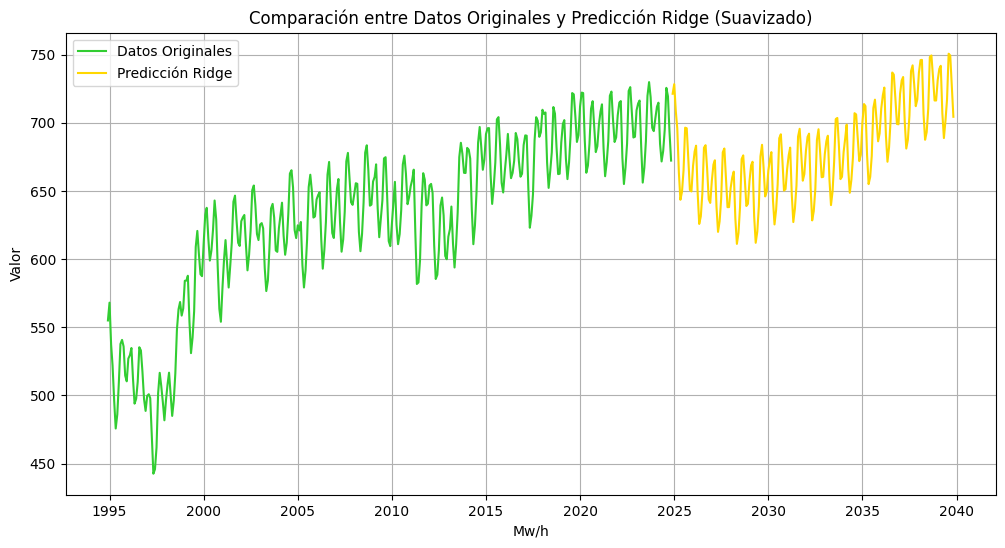

In [51]:
import matplotlib.pyplot as plt

# Calcular la media móvil de 4 meses para mejor visualizacion
Y_suavizado = Y_escalado.rolling(window=4, min_periods=1).mean()
pred_suavizado = pred_ridge_NetGeneration.rolling(window=4, min_periods=1).mean()

# Graficar la serie original y la predicción suavizadas
plt.figure(figsize=(12, 6))
plt.plot(Y_suavizado, label="Datos Originales", color="limegreen")
plt.plot(pred_suavizado, label="Predicción Ridge", color="gold")

# Agregar títulos y leyenda
plt.xlabel("Mw/h")
plt.ylabel("Valor")
plt.title("Comparación entre Datos Originales y Predicción Ridge (Suavizado)")
plt.legend()
plt.grid()

# Mostrar la gráfica
plt.show()
